<a href="https://colab.research.google.com/github/eejd/course-content/blob/2021-bayes/tutorials/W2D1_BayesianStatistics/W2D1_Tutorial2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neuromatch Academy: Week 3, Day 1, Tutorial 2
# Bayesian inference and decisions with continuous hidden state

__Content creators:__ Eric DeWitt, Xaq Pitkow, Saeed Salehi, Ella Betty

__Content reviewers:__ 

# Tutorial Objectives

This notebook introduces you to Gaussians and Bayes' rule for continuous distributions, allowing us to model simple put powerful combinations of prior information and new measurements. In this notebook you will work through the same ideas we explored in the binary state tutorial, but you will be introduced to a new problem: finding and guiding Astrocat! You will see this problem again in more complex ways in the following days.

In this notebook, you will:

1. Learn about the Gaussian distribution and it's nice properies
2. Explore how we can extend the ideas from the binary hidden tutorial to continuous distributions
3. Explore how different priors can produce more complex posteriors.
4. Explore Loss functions often used in inference and complex utility functions.

Video available at https://youtube.com/watch?v=GdIwJWsW9-s


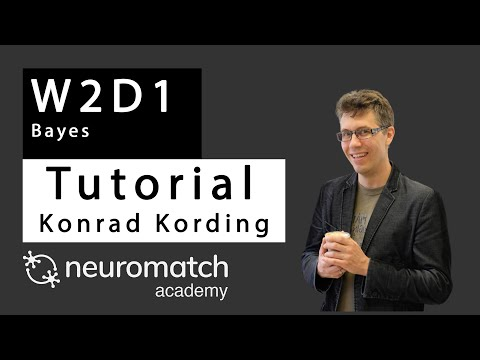

In [1]:
# @title Video 1: Introduction
from IPython.display import YouTubeVideo
video = YouTubeVideo(id='GdIwJWsW9-s', width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)
video

---
##Setup  
Please execute the cells below to initialize the notebook environment.

In [2]:
# imports
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import multivariate_normal
from scipy.stats import gamma as gamma_distribution
from matplotlib.transforms import Affine2D

In [3]:
#@title Figure Settings
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import ipywidgets as widgets
from ipywidgets import FloatSlider
from ipywidgets import interact, fixed, HBox, Layout, VBox, interactive, Label
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/nma.mplstyle")

In [4]:
def gaussian(x, μ, σ):
    return np.exp(-((x - μ) / σ)**2 / 2) / np.sqrt(2 * np.pi * σ**2)


def gamma_pdf(x, α, β):
    return gamma_distribution.pdf(x, a=α, scale=1/β)


def mvn2d(x, y, mu1, mu2, sigma1, sigma2, cov12):
    mvn = multivariate_normal([mu1, mu2], [[sigma1**2, cov12], [cov12, sigma2**2]])
    return mvn.pdf(np.dstack((x, y)))


def product_guassian(mu1, mu2, sigma1, sigma2):
    J_1, J_2 = 1/sigma1**2, 1/sigma2**2
    J_3 = J_1 + J_2
    mu_prod = (J_1*mu1/J_3) + (J_2*mu2/J_3)
    sigma_prod = np.sqrt(1/J_3)
    return mu_prod, sigma_prod


def reverse_product(mu3, sigma3, mu1, mu2):
    J_3 = 1/sigma3**2
    J_1 = J_3 * (mu3 - mu2) / (mu1 - mu2)
    J_2 = J_3 * (mu3 - mu1) / (mu2 - mu1)
    sigma1, sigma2 = 1/np.sqrt(J_1), 1/np.sqrt(J_2)
    return sigma1, sigma2


def calc_mean_mode_median(x, y):
    """

    """
    pdf = y * (x[1] - x[0])
    # Calc mode of an arbitrary function
    mode = x[np.argmax(pdf)]

    # Calc mean of an arbitrary function
    mean = np.multiply(x, pdf).sum()

    # Calc median of an arbitrary function
    cdf = np.cumsum(pdf)
    idx = np.argmin(np.abs(cdf - 0.5))
    median = x[idx]

    return mean, median, mode


def calc_loss_func(loss_f, mu_true, x):
    error = x - mu_true
    if loss_f == "Mean Squared Error":
        loss = (error)**2
    elif loss_f == "Absolute Error":
        loss = np.abs(error)
    elif loss_f == "Zero-One Loss":
        loss = (np.abs(error) >= 0.03).astype(np.float)
    return loss


def calc_expected_loss(loss_f, posterior, x):
    dx = x[1] - x[0]
    expected_loss = np.zeros_like(x)
    for i in np.arange(x.shape[0]):
        loss = calc_loss_func(loss_f, x[i], x) # or mse or zero_one_loss
        expected_loss[i] = np.sum(loss * posterior) * dx
    return expected_loss


def plot_gaussian(μ, σ):
    x = np.linspace(-7, 7, 1000, endpoint=True)
    y = gaussian(x, μ, σ)

    plt.figure(figsize=(6, 4))
    plt.plot(x, y, c='blue')
    plt.fill_between(x, y, color='b', alpha=0.2)
    plt.ylabel('$\mathcal{N}(x, \mu, \sigma^2)$')
    plt.xlabel('x')
    plt.yticks([])
    plt.show()

def plot_losses(μ, σ):
    x = np.linspace(-2, 2, 400, endpoint=True)
    y = gaussian(x, μ, σ)
    error = x - μ

    mse_loss = (error)**2
    abs_loss = np.abs(error)
    zero_one_loss = (np.abs(error) >= 0.02).astype(np.float)

    fig, (ax_gaus, ax_error) = plt.subplots(2, 1, figsize=(6, 8))
    ax_gaus.plot(x, y, color='blue', label='true distribution')
    ax_gaus.fill_between(x, y, color='blue', alpha=0.2)
    ax_gaus.set_ylabel('$\\mathcal{N}(x, \\mu, \\sigma^2)$')
    ax_gaus.set_xlabel('x')
    ax_gaus.set_yticks([])
    ax_gaus.legend(loc='upper right')

    ax_error.plot(x, mse_loss, color='c', label='Mean Squared Error', linewidth=3)
    ax_error.plot(x, abs_loss, color='m', label='Absolute Error', linewidth=3)
    ax_error.plot(x, zero_one_loss, color='y', label='Zero-One Loss', linewidth=3)
    ax_error.legend(loc='upper right')
    ax_error.set_xlabel('$\\hat{\\mu}$')
    ax_error.set_ylabel('Error')
    plt.show()

def plot_mvn2d(mu1, mu2, sigma1, sigma2, corr):
    x, y = np.mgrid[-2:2:.02, -2:2:.02]
    cov12 = corr * sigma1 * sigma2
    z = mvn2d(x, y, mu1, mu2, sigma1, sigma2, cov12)

    plt.figure(figsize=(6, 6))
    plt.contourf(x, y, z, cmap='Reds')
    plt.axis("off")
    plt.show()


def plot_marginal(sigma1, sigma2, c_x, c_y, corr):
    mu1, mu2 = 0.0, 0.0
    cov12 = corr * sigma1 * sigma2
    xx, yy = np.mgrid[-2:2:.02, -2:2:.02]
    x, y = xx[:, 0], yy[0]
    p_x = gaussian(x, mu1, sigma1)
    p_y = gaussian(y, mu2, sigma2)
    zz = mvn2d(xx, yy, mu1, mu2, sigma1, sigma2, cov12)

    mu_x_y = mu1+cov12*(c_y-mu2)/sigma2**2
    mu_y_x = mu2+cov12*(c_x-mu1)/sigma1**2
    sigma_x_y = np.sqrt(sigma2**2 - cov12**2/sigma1**2)
    sigma_y_x = np.sqrt(sigma1**2-cov12**2/sigma2**2)
    p_x_y = gaussian(x, mu_x_y, sigma_x_y)
    p_y_x = gaussian(x, mu_y_x, sigma_y_x)

    p_c_y = gaussian(mu_x_y-sigma_x_y, mu_x_y, sigma_x_y)
    p_c_x = gaussian(mu_y_x-sigma_y_x, mu_y_x, sigma_y_x)

    # definitions for the axes
    left, width = 0.1, 0.65
    bottom, height = 0.1, 0.65
    spacing = 0.01

    rect_z = [left, bottom, width, height]
    rect_x = [left, bottom + height + spacing, width, 0.2]
    rect_y = [left + width + spacing, bottom, 0.2, height]

    # start with a square Figure
    fig = plt.figure(figsize=(8, 8))

    ax_z = fig.add_axes(rect_z)
    ax_x = fig.add_axes(rect_x, sharex=ax_z)
    ax_y = fig.add_axes(rect_y, sharey=ax_z)

    ax_z.set_axis_off()
    ax_x.set_axis_off()
    ax_y.set_axis_off()
    ax_x.set_xlim(np.min(x), np.max(x))
    ax_y.set_ylim(np.min(y), np.max(y))

    ax_z.contourf(xx, yy, zz, cmap='Greys')
    ax_z.hlines(c_y, mu_x_y-sigma_x_y, mu_x_y+sigma_x_y, color='c', zorder=9, linewidth=3)
    ax_z.vlines(c_x, mu_y_x-sigma_y_x, mu_y_x+sigma_y_x, color='m', zorder=9, linewidth=3)

    ax_x.plot(x, p_x, label='$p(x)$', c = 'b', linewidth=3)
    ax_x.plot(x, p_x_y, label='$p(x|y = C_y)$', c = 'c', linestyle='dashed', linewidth=3)
    ax_x.hlines(p_c_y, mu_x_y-sigma_x_y, mu_x_y+sigma_x_y, color='c', linestyle='dashed', linewidth=3)

    ax_y.plot(p_y, y, label='$p(y)$', c = 'r', linewidth=3)
    ax_y.plot(p_y_x, y, label='$p(y|x = C_x)$', c = 'm', linestyle='dashed', linewidth=3)
    ax_y.vlines(p_c_x, mu_y_x-sigma_y_x, mu_y_x+sigma_y_x, color='m', linestyle='dashed', linewidth=3)


    ax_x.legend(loc="upper left", frameon=False)
    ax_y.legend(loc="lower right", frameon=False)

    plt.show()


def plot_bayes(mu1, mu2, sigma1, sigma2):
    x = np.linspace(-7, 7, 1000, endpoint=True)
    prior = gaussian(x, mu1, sigma1)
    likelihood = gaussian(x, mu2, sigma2)

    mu_post, sigma_post = product_guassian(mu1, mu2, sigma1, sigma2)
    posterior = gaussian(x, mu_post, sigma_post)
    
    plt.figure(figsize=(8, 6))
    plt.plot(x, prior, c='b', label='prior')
    plt.fill_between(x, prior, color='b', alpha=0.2)
    plt.plot(x, likelihood, c='r', label='likelihood')
    plt.fill_between(x, likelihood, color='r', alpha=0.2)
    plt.plot(x, posterior, c='k', label='posterior')
    plt.fill_between(x, posterior, color='k', alpha=0.2)
    plt.yticks([])
    plt.legend(loc="upper left")
    plt.ylabel('$\mathcal{N}(x, \mu, \sigma^2)$')
    plt.xlabel('x')
    plt.show()

def plot_information(mu1, sigma1, mu2, sigma2):
    x = np.linspace(-7, 7, 1000, endpoint=True)
    mu3, sigma3 = product_guassian(mu1, mu2, sigma1, sigma2)
    prior = gaussian(x, mu1, sigma1)
    likelihood = gaussian(x, mu2, sigma2)
    posterior = gaussian(x, mu3, sigma3)

    plt.figure(figsize=(8, 6))
    plt.plot(x, prior, c='b', label='Satellite')
    plt.fill_between(x, prior, color='b', alpha=0.2)
    plt.plot(x, likelihood, c='r', label='Space Mouse')
    plt.fill_between(x, likelihood, color='r', alpha=0.2)
    plt.plot(x, posterior, c='k', label='Center')
    plt.fill_between(x, posterior, color='k', alpha=0.2)
    plt.yticks([])
    plt.legend(loc="upper left")
    plt.ylabel('$\mathcal{N}(x, \mu, \sigma^2)$')
    plt.xlabel('x')
    plt.show()

def plot_information_global(mu3, sigma3, mu1, mu2):
    x = np.linspace(-7, 7, 1000, endpoint=True)
    sigma1, sigma2 = reverse_product(mu3, sigma3, mu1, mu2)
    prior = gaussian(x, mu1, sigma1)
    likelihood = gaussian(x, mu2, sigma2)
    posterior = gaussian(x, mu3, sigma3)

    plt.figure(figsize=(8, 6))
    plt.plot(x, prior, c='b', label='Satellite')
    plt.fill_between(x, prior, color='b', alpha=0.2)
    plt.plot(x, likelihood, c='r', label='Space Mouse')
    plt.fill_between(x, likelihood, color='r', alpha=0.2)
    plt.plot(x, posterior, c='k', label='Center')
    plt.fill_between(x, posterior, color='k', alpha=0.2)
    plt.yticks([])
    plt.legend(loc="upper left")
    plt.ylabel('$\mathcal{N}(x, \mu, \sigma^2)$')
    plt.xlabel('x')
    plt.show()


def plot_loss_utility_gaussian(loss_f, mu, sigma, mu_true):
    x = np.linspace(-7, 7, 1000, endpoint=True)
    posterior = gaussian(x, mu, sigma)
    mean, median, mode = mu, mu, mu

    loss = calc_loss_func(loss_f, mu_true, x)

    utility = - calc_expected_loss(loss_f, posterior, x)

    plt.figure(figsize=(18, 5))
    plt.subplot(1, 3, 1)
    plt.title("Probability")
    plt.plot(x, posterior, c='b')
    plt.fill_between(x, posterior, color='b', alpha=0.2)
    plt.yticks([])
    plt.xlabel('x')
    plt.ylabel('$\mathcal{N}(x, \mu, \sigma^2)$')
    plt.axvline(mean, ls='dashed', color='red', label='Mean')
    plt.axvline(median, ls='dashdot', color='blue', label='Median')
    plt.axvline(mode, ls='dotted', color='green', label='Mode')
    plt.legend(loc="upper left")
    
    plt.subplot(1, 3, 2)
    plt.title(loss_f)
    plt.plot(x, loss, c='c', label=loss_f)
    # plt.fill_between(x, loss, color='c', alpha=0.2)
    plt.ylabel('loss')
    # plt.legend(loc="upper left")

    plt.subplot(1, 3, 3)
    plt.title("Expected utility")
    plt.plot(x, utility, c='y', label='utility')
    # plt.fill_between(x, utility, color='y', alpha=0.2)
    plt.legend(loc="upper left")

    plt.show()


def plot_loss_utility_mixture(loss_f, mu1, mu2, sigma1, sigma2, factor, mu_true):

    x = np.linspace(-7, 7, 1000, endpoint=True)
    y_1 = gaussian(x, mu1, sigma1)
    y_2 = gaussian(x, mu2, sigma2)

    posterior = y_1 * factor + y_2 * (1.0 - factor)
    
    mean, median, mode = calc_mean_mode_median(x, posterior)

    loss = calc_loss_func(loss_f, mu_true, x)

    utility = - calc_expected_loss(loss_f, posterior, x)

    plt.figure(figsize=(18, 5))
    plt.subplot(1, 3, 1)
    plt.title("Probability")
    plt.plot(x, posterior, c='b')
    plt.fill_between(x, posterior, color='b', alpha=0.2)
    plt.yticks([])
    plt.xlabel('x')
    plt.ylabel('$\pi \cdot p(x) + (1-\pi) \cdot p(y)$')
    plt.axvline(mean, ls='dashed', color='red', label='Mean')
    plt.axvline(median, ls='dashdot', color='blue', label='Median')
    plt.axvline(mode, ls='dotted', color='green', label='Mode')
    plt.legend(loc="upper left")
    
    plt.subplot(1, 3, 2)
    plt.title(loss_f)
    plt.plot(x, loss, c='c', label=loss_f)
    # plt.fill_between(x, loss, color='c', alpha=0.2)
    plt.ylabel('loss')
    # plt.legend(loc="upper left")

    plt.subplot(1, 3, 3)
    plt.title("Expected utility")
    plt.plot(x, utility, c='y', label='utility')
    # plt.fill_between(x, utility, color='y', alpha=0.2)
    plt.legend(loc="upper left")

    plt.show()


def plot_loss_utility_bayes(mu1, mu2, sigma1, sigma2, mu_true, loss_f):
    x = np.linspace(-4, 4, 1000, endpoint=True)

    prior = gaussian(x, mu1, sigma1)
    likelihood = gaussian(x, mu2, sigma2)

    mu_post, sigma_post = product_guassian(mu1, mu2, sigma1, sigma2)
    posterior = gaussian(x, mu_post, sigma_post)

    loss = calc_loss_func(loss_f, mu_true, x)

    utility = - calc_expected_loss(loss_f, posterior, x)

    plt.figure(figsize=(18, 5))
    plt.subplot(1, 3, 1)

    plt.title("Posterior distribution")
    plt.plot(x, prior, c='b', label='prior')
    plt.fill_between(x, prior, color='b', alpha=0.2)
    plt.plot(x, likelihood, c='r', label='likelihood')
    plt.fill_between(x, likelihood, color='r', alpha=0.2)
    plt.plot(x, posterior, c='k', label='posterior')
    plt.fill_between(x, posterior, color='k', alpha=0.2)
    plt.yticks([])
    plt.legend(loc="upper left")
    # plt.ylabel('$f(x)$')
    plt.xlabel('x')

    plt.subplot(1, 3, 2)
    plt.title(loss_f)
    plt.plot(x, loss, c='c')
    # plt.fill_between(x, loss, color='c', alpha=0.2)
    plt.ylabel('loss')

    plt.subplot(1, 3, 3)
    plt.title("Expected utility")
    plt.plot(x, utility, c='y', label='utility')
    # plt.fill_between(x, utility, color='y', alpha=0.2)
    plt.legend(loc="upper left")

    plt.show()


def plot_simple_utility_gaussian(mu, sigma, mu_g, mu_c, sigma_g, sigma_c):
    x = np.linspace(-7, 7, 1000, endpoint=True)
    posterior = gaussian(x, mu, sigma)
    gain = gaussian(x, mu_g, sigma_g)
    loss = gaussian(x, mu_c, sigma_c)
    utility = np.multiply(posterior, gain) - np.multiply(posterior, loss)

    plt.figure(figsize=(18, 5))
    plt.subplot(1, 3, 1)
    plt.title("Probability")
    plt.plot(x, posterior, c='b', label='posterior')
    plt.fill_between(x, posterior, color='b', alpha=0.2)
    plt.yticks([])
    # plt.legend(loc="upper left")
    plt.xlabel('x')

    plt.subplot(1, 3, 2)
    plt.title("utility function")
    plt.plot(x, gain, c='m', label='gain')
    # plt.fill_between(x, gain, color='m', alpha=0.2)
    plt.plot(x, -loss, c='c', label='loss')
    # plt.fill_between(x, -loss, color='c', alpha=0.2)
    plt.legend(loc="upper left")

    plt.subplot(1, 3, 3)
    plt.title("expected utility")
    plt.plot(x, utility, c='y', label='utility')
    # plt.fill_between(x, utility, color='y', alpha=0.2)
    plt.legend(loc="upper left")

    plt.show()


def plot_utility_gaussian(mu1, mu2, sigma1, sigma2, mu_g, mu_c, sigma_g, sigma_c):
    x = np.linspace(-7, 7, 1000, endpoint=True)
    prior = gaussian(x, mu1, sigma1)
    likelihood = gaussian(x, mu2, sigma2)
    gain = gaussian(x, mu_g, sigma_g)
    loss = gaussian(x, mu_c, sigma_c)

    mu_post, sigma_post = product_guassian(mu1, mu2, sigma1, sigma2)
    posterior = gaussian(x, mu_post, sigma_post)

    utility = np.multiply(posterior, gain) - np.multiply(posterior, loss)

    plot_utility(x, prior, likelihood, posterior, gain, loss, utility)

    return None


def plot_utility_mixture(mu_m1, mu_m2, sigma_m1, sigma_m2, factor,
                         mu, sigma, mu_g, mu_c, sigma_g, sigma_c):
    x = np.linspace(-7, 7, 1000, endpoint=True)
    y_1 = gaussian(x, mu_m1, sigma_m1)
    y_2 = gaussian(x, mu_m2, sigma_m2)
    prior = y_1 * factor + y_2 * (1.0 - factor)

    likelihood = gaussian(x, mu, sigma)
    gain = gaussian(x, mu_g, sigma_g)
    loss = gaussian(x, mu_c, sigma_c)

    posterior = np.multiply(prior, likelihood)
    posterior = posterior / (posterior.sum() * (x[1] - x[0]))

    utility = np.multiply(posterior, gain) - np.multiply(posterior, loss)

    plot_utility(x, prior, likelihood, posterior, gain, loss, utility)

    return None


def plot_utility_uniform(mu, sigma, mu_g, mu_c, sigma_g, sigma_c):
    x = np.linspace(-7, 7, 1000, endpoint=True)
    prior = np.ones_like(x) / (x.max() - x.min())
    likelihood = gaussian(x, mu, sigma)
    gain = gaussian(x, mu_g, sigma_g)
    loss = gaussian(x, mu_c, sigma_c)

    posterior = likelihood
    # posterior = np.multiply(prior, likelihood)
    # posterior = posterior / (posterior.sum() * (x[1] - x[0]))

    utility = np.multiply(posterior, gain) - np.multiply(posterior, loss)

    plot_utility(x, prior, likelihood, posterior, gain, loss, utility)

    return None


def plot_utility_gamma(alpha, beta, offset, mu, sigma, mu_g, mu_c, sigma_g, sigma_c):
    x = np.linspace(-7, 7, 1000, endpoint=True)
    prior = gamma_pdf(x-offset, alpha, beta)
    likelihood = gaussian(x, mu, sigma)
    gain = gaussian(x, mu_g, sigma_g)
    loss = gaussian(x, mu_c, sigma_c)

    posterior = np.multiply(prior, likelihood)
    posterior = posterior / (posterior.sum() * (x[1] - x[0]))

    utility = np.multiply(posterior, gain) - np.multiply(posterior, loss)

    plot_utility(x, prior, likelihood, posterior, gain, loss, utility)

    return None


def plot_utility(x, prior, likelihood, posterior, gain, loss, utility):
    plt.figure(figsize=(18, 5))
    plt.subplot(1, 3, 1)
    plt.title("Posterior distribution")
    plt.plot(x, prior, c='b', label='prior')
    plt.fill_between(x, prior, color='b', alpha=0.2)
    plt.plot(x, likelihood, c='r', label='likelihood')
    plt.fill_between(x, likelihood, color='r', alpha=0.2)
    plt.plot(x, posterior, c='k', label='posterior')
    plt.fill_between(x, posterior, color='k', alpha=0.2)
    plt.yticks([])
    plt.legend(loc="upper left")
    # plt.ylabel('$f(x)$')
    plt.xlabel('x')

    plt.subplot(1, 3, 2)
    plt.title("utility function")
    plt.plot(x, gain, c='m', label='gain')
    # plt.fill_between(x, gain, color='m', alpha=0.2)
    plt.plot(x, -loss, c='c', label='loss')
    # plt.fill_between(x, -loss, color='c', alpha=0.2)
    plt.legend(loc="upper left")

    plt.subplot(1, 3, 3)
    plt.title("expected utility")
    plt.plot(x, utility, c='y', label='utility')
    # plt.fill_between(x, utility, color='y', alpha=0.2)
    plt.legend(loc="upper left")

    plt.show()


def gaussian_mixture(mu1, mu2, sigma1, sigma2, factor):
    assert 0.0 < factor < 1.0
    x = np.linspace(-7.0, 7.0, 1000, endpoint=True)
    y_1 = gaussian(x, mu1, sigma1)
    y_2 = gaussian(x, mu2, sigma2)
    mixture = y_1 * factor + y_2 * (1.0 - factor)
    
    plt.figure(figsize=(8, 6))
    plt.plot(x, y_1, c='deepskyblue', label='p(x)', linewidth=3.0)
    plt.fill_between(x, y_1, color='deepskyblue', alpha=0.2)
    plt.plot(x, y_2, c='aquamarine', label='p(y)', linewidth=3.0)
    plt.fill_between(x, y_2, color='aquamarine', alpha=0.2)
    plt.plot(x, mixture, c='b', label='$\pi \cdot p(x) + (1-\pi) \cdot p(y)$',  linewidth=3.0)
    plt.fill_between(x, mixture, color='b', alpha=0.2)
    plt.yticks([])
    plt.legend(loc="upper left")
    # plt.ylabel('$f(x)$')
    plt.xlabel('x')
    plt.show()


def plot_bayes_loss_utility_gaussian(loss_f, mu_true, mu1, mu2, sigma1, sigma2):
    x = np.linspace(-7, 7, 1000, endpoint=True)

    prior = gaussian(x, mu1, sigma1)
    likelihood = gaussian(x, mu2, sigma2)
    mu_post, sigma_post = product_guassian(mu1, mu2, sigma1, sigma2)
    posterior = gaussian(x, mu_post, sigma_post)

    loss = calc_loss_func(loss_f, mu_true, x)

    plot_bayes_loss_utility(x, prior, likelihood, posterior, loss, loss_f)

    return None


def plot_bayes_loss_utility_uniform(loss_f, mu_true, mu, sigma):
    x = np.linspace(-7, 7, 1000, endpoint=True)

    prior = np.ones_like(x) / (x.max() - x.min())
    likelihood = gaussian(x, mu, sigma)
    posterior = likelihood

    loss = calc_loss_func(loss_f, mu_true, x)

    plot_bayes_loss_utility(x, prior, likelihood, posterior, loss, loss_f)

    return None


def plot_bayes_loss_utility_gamma(loss_f, mu_true, alpha, beta, offset, mu, sigma):
    x = np.linspace(-7, 7, 1000, endpoint=True)
    prior = gamma_pdf(x-offset, alpha, beta)
    likelihood = gaussian(x, mu, sigma)
    posterior = np.multiply(prior, likelihood)
    posterior = posterior / (posterior.sum() * (x[1] - x[0]))

    loss = calc_loss_func(loss_f, mu_true, x)

    plot_bayes_loss_utility(x, prior, likelihood, posterior, loss, loss_f)

    return None


def plot_bayes_loss_utility_mixture(loss_f, mu_true, mu_m1, mu_m2, sigma_m1, sigma_m2, factor, mu, sigma):
    x = np.linspace(-7, 7, 1000, endpoint=True)
    y_1 = gaussian(x, mu_m1, sigma_m1)
    y_2 = gaussian(x, mu_m2, sigma_m2)
    prior = y_1 * factor + y_2 * (1.0 - factor)
    likelihood = gaussian(x, mu, sigma)

    posterior = np.multiply(prior, likelihood)
    posterior = posterior / (posterior.sum() * (x[1] - x[0]))

    loss = calc_loss_func(loss_f, mu_true, x)

    plot_bayes_loss_utility(x, prior, likelihood, posterior, loss, loss_f)

    return None


def plot_bayes_loss_utility(x, prior, likelihood, posterior, loss, loss_f):
    plt.figure(figsize=(18, 3.5))

    plt.subplot(1, 4, 1)
    plt.title("Prior and Likelihood")
    plt.plot(x, prior, c='b', label='prior')
    plt.fill_between(x, prior, color='b', alpha=0.2)
    plt.plot(x, likelihood, c='r', label='likelihood')
    plt.fill_between(x, likelihood, color='r', alpha=0.2)
    plt.yticks([])
    plt.legend(loc="upper left")
    plt.xlabel('x')

    plt.subplot(1, 4, 2)
    plt.title("Posterior")
    plt.plot(x, posterior, c='k', label='posterior')
    plt.fill_between(x, posterior, color='k', alpha=0.1)

    mean, median, mode = calc_mean_mode_median(x, posterior)
    plt.axvline(mean, ls='dashed', color='red', label='Mean')
    plt.axvline(median, ls='dashdot', color='blue', label='Median')
    plt.axvline(mode, ls='dotted', color='green', label='Mode')
    plt.legend(loc="upper left")
    plt.yticks([])

    plt.subplot(1, 4, 3)
    plt.title(loss_f)
    plt.plot(x, loss, c='c', label=loss_f)
    # plt.fill_between(x, loss, color='c', alpha=0.2)
    plt.ylabel('loss')

    plt.subplot(1, 4, 4)
    expected_loss = calc_expected_loss(loss_f, posterior, x)
    min_expected_loss = x[np.argmin(expected_loss)]
    plt.title("expected loss")
    plt.plot(x, expected_loss, c='y', label='expected loss')
    # plt.fill_between(x, expected_loss, color='y', alpha=0.2)
    plt.axvline(min_expected_loss, ls='dashed', color='red', label='$Min~ \mathbb{E}[Loss]$')
    plt.legend(loc="lower right")

    plt.show()


def loss_plot_switcher(what_to_plot):
    if what_to_plot == "Gaussian":
        widget = interact(plot_loss_utility_gaussian,
            loss_f = widgets.Dropdown(
                options=["Mean Squared Error", "Absolute Error", "Zero-One Loss"], 
                value="Mean Squared Error", description="Loss: "),
            mu = FloatSlider(min=-4.0, max=4.0, step=0.01, value=-0.5, description="µ_estimate", continuous_update=False),
            sigma = FloatSlider(min=0.1, max=2.0, step=0.01, value=0.5, description="σ_estimate", continuous_update=False),
            mu_true = FloatSlider(min=-3.0, max=3.0, step=0.01, value=0.0, description="µ_true", continuous_update=False))
    elif what_to_plot == "Mixture of Gaussians":
        widget = interact(plot_loss_utility_mixture,
            mu1 = FloatSlider(min=-4.0, max=4.0, step=0.01, value=-0.5, description="µ_est_1", continuous_update=False),
            mu2 = FloatSlider(min=-4.0, max=4.0, step=0.01, value=-0.5, description="µ_est_2", continuous_update=False),
            sigma1 = FloatSlider(min=0.1, max=2.0, step=0.01, value=0.5, description="σ_est_1", continuous_update=False),
            sigma2 = FloatSlider(min=0.1, max=2.0, step=0.01, value=0.5, description="σ_est_2", continuous_update=False),
            factor = FloatSlider(min=0.0, max=1.0, step=0.01, value=0.5, description="π", continuous_update=False),
            mu_true = FloatSlider(min=-3.0, max=3.0, step=0.01, value=0.0, description="µ_true", continuous_update=False),
            loss_f = widgets.Dropdown(
                options=["Mean Squared Error", "Absolute Error", "Zero-One Loss"], 
                value="Mean Squared Error", description="Loss: "))


def plot_prior_switcher(what_to_plot):
    if what_to_plot == "Gaussian":
        widget = interact(plot_utility_gaussian,
                  mu1 = FloatSlider(min=-4.0, max=4.0, step=0.01, value=-0.5, description="µ_prior", continuous_update=False),
                  mu2 = FloatSlider(min=-4.0, max=4.0, step=0.01, value=0.5, description="µ_likelihood", continuous_update=False),
                  sigma1 = FloatSlider(min=0.1, max=2.0, step=0.01, value=0.5, description="σ_prior", continuous_update=False),
                  sigma2 = FloatSlider(min=0.1, max=2.0, step=0.01, value=0.5, description="σ_likelihood", continuous_update=False),
                  mu_g = FloatSlider(min=-4.0, max=4.0, step=0.01, value=1.0, description="µ_gain", continuous_update=False),
                  mu_c = FloatSlider(min=-4.0, max=4.0, step=0.01, value=-1.0, description="µ_cost", continuous_update=False),
                  sigma_g = FloatSlider(min=0.1, max=2.0, step=0.01, value=0.5, description="σ_gain", continuous_update=False),
                  sigma_c = FloatSlider(min=0.1, max=2.0, step=0.01, value=0.5, description="σ_cost", continuous_update=False))
    elif what_to_plot == "Uniform":
        widget = interact(plot_utility_uniform,
                  mu = FloatSlider(min=-4.0, max=4.0, step=0.01, value=0.5, description="µ_likelihood", continuous_update=False),
                  sigma = FloatSlider(min=0.1, max=2.0, step=0.01, value=0.5, description="σ_likelihood", continuous_update=False),
                  mu_g = FloatSlider(min=-4.0, max=4.0, step=0.01, value=1.0, description="µ_gain", continuous_update=False),
                  mu_c = FloatSlider(min=-4.0, max=4.0, step=0.01, value=-1.0, description="µ_cost", continuous_update=False),
                  sigma_g = FloatSlider(min=0.1, max=2.0, step=0.01, value=0.5, description="σ_gain", continuous_update=False),
                  sigma_c = FloatSlider(min=0.1, max=2.0, step=0.01, value=0.5, description="σ_cost", continuous_update=False))
    elif what_to_plot == "Gamma":
        widget = interact(plot_utility_gamma,
                  alpha = FloatSlider(min=1.0, max=10.0, step=0.1, value=2.0, description="α_prior", continuous_update=False),
                  beta = FloatSlider(min=0.5, max=2.0, step=0.01, value=1.0, description="β_prior", continuous_update=False),
                  offset = FloatSlider(min=-6.0, max=2.0, step=0.1, value=0.0, description="offset", continuous_update=False),
                  mu = FloatSlider(min=-4.0, max=4.0, step=0.01, value=0.5, description="µ_likelihood", continuous_update=False),
                  sigma = FloatSlider(min=0.1, max=2.0, step=0.01, value=0.5, description="σ_likelihood", continuous_update=False),
                  mu_g = FloatSlider(min=-4.0, max=4.0, step=0.01, value=1.0, description="µ_gain", continuous_update=False),
                  mu_c = FloatSlider(min=-4.0, max=4.0, step=0.01, value=-1.0, description="µ_cost", continuous_update=False),
                  sigma_g = FloatSlider(min=0.1, max=2.0, step=0.01, value=0.5, description="σ_gain", continuous_update=False),
                  sigma_c = FloatSlider(min=0.1, max=2.0, step=0.01, value=0.5, description="σ_cost", continuous_update=False))
    elif what_to_plot == "Mixture of Gaussians":
        widget = interact(plot_utility_mixture,
                  mu_m1 = FloatSlider(min=-4.0, max=4.0, step=0.01, value=-0.5, description="µ_mix_1", continuous_update=False),
                  mu_m2 = FloatSlider(min=-4.0, max=4.0, step=0.01, value=0.5, description="µ_mix_1", continuous_update=False),
                  sigma_m1 = FloatSlider(min=0.1, max=2.0, step=0.01, value=0.5, description="σ_mix_1", continuous_update=False),
                  sigma_m2 = FloatSlider(min=0.1, max=2.0, step=0.01, value=0.5, description="σ_mix_2", continuous_update=False),
                  factor = FloatSlider(min=0.0, max=1.0, step=0.01, value=0.5, description="π", continuous_update=False),
                  mu = FloatSlider(min=-4.0, max=4.0, step=0.01, value=0.5, description="µ_likelihood", continuous_update=False),
                  sigma = FloatSlider(min=0.1, max=2.0, step=0.01, value=0.5, description="σ_likelihood", continuous_update=False),
                  mu_g = FloatSlider(min=-4.0, max=4.0, step=0.01, value=1.0, description="µ_gain", continuous_update=False),
                  mu_c = FloatSlider(min=-4.0, max=4.0, step=0.01, value=-1.0, description="µ_cost", continuous_update=False),
                  sigma_g = FloatSlider(min=0.1, max=2.0, step=0.01, value=0.5, description="σ_gain", continuous_update=False),
                  sigma_c = FloatSlider(min=0.1, max=2.0, step=0.01, value=0.5, description="σ_cost", continuous_update=False))
        
def plot_bayes_loss_utility_switcher(what_to_plot):
    if what_to_plot == "Gaussian":
        widget = interact(plot_bayes_loss_utility_gaussian,
                  mu1 = FloatSlider(min=-4.0, max=4.0, step=0.01, value=-0.5, description="µ_prior", continuous_update=False),
                  mu2 = FloatSlider(min=-4.0, max=4.0, step=0.01, value=0.5, description="µ_likelihood", continuous_update=False),
                  sigma1 = FloatSlider(min=0.1, max=2.0, step=0.01, value=0.5, description="σ_prior", continuous_update=False),
                  sigma2 = FloatSlider(min=0.1, max=2.0, step=0.01, value=0.5, description="σ_likelihood", continuous_update=False),
                  mu_true = FloatSlider(min=-4.0, max=4.0, step=0.01, value=-0.5, description="µ_true", continuous_update=False),
                  loss_f = widgets.Dropdown(
                      options=["Mean Squared Error", "Absolute Error", "Zero-One Loss"], 
                      value="Mean Squared Error", description="Loss: "))
    elif what_to_plot == "Uniform":
        widget = interact(plot_bayes_loss_utility_uniform,
                  mu = FloatSlider(min=-4.0, max=4.0, step=0.01, value=0.5, description="µ_likelihood", continuous_update=False),
                  sigma = FloatSlider(min=0.1, max=2.0, step=0.01, value=0.5, description="σ_likelihood", continuous_update=False),
                  mu_true = FloatSlider(min=-4.0, max=4.0, step=0.01, value=-0.5, description="µ_true", continuous_update=False),
                  loss_f = widgets.Dropdown(
                      options=["Mean Squared Error", "Absolute Error", "Zero-One Loss"], 
                      value="Mean Squared Error", description="Loss: "))
    elif what_to_plot == "Gamma":
        widget = interact(plot_bayes_loss_utility_gamma,
                  alpha = FloatSlider(min=1.0, max=10.0, step=0.1, value=2.0, description="α_prior", continuous_update=False),
                  beta = FloatSlider(min=0.5, max=2.0, step=0.01, value=1.0, description="β_prior", continuous_update=False),
                  offset = FloatSlider(min=-6.0, max=2.0, step=0.1, value=0.0, description="offset", continuous_update=False),
                  mu = FloatSlider(min=-4.0, max=4.0, step=0.01, value=0.5, description="µ_likelihood", continuous_update=False),
                  sigma = FloatSlider(min=0.1, max=2.0, step=0.01, value=0.5, description="σ_likelihood", continuous_update=False),
                  mu_true = FloatSlider(min=-4.0, max=4.0, step=0.01, value=-0.5, description="µ_true", continuous_update=False),
                  loss_f = widgets.Dropdown(
                      options=["Mean Squared Error", "Absolute Error", "Zero-One Loss"], 
                      value="Mean Squared Error", description="Loss: "))
    elif what_to_plot == "Mixture of Gaussians":
        widget = interact(plot_bayes_loss_utility_mixture,
                  mu_m1 = FloatSlider(min=-4.0, max=4.0, step=0.01, value=-0.5, description="µ_mix_1", continuous_update=False),
                  mu_m2 = FloatSlider(min=-4.0, max=4.0, step=0.01, value=0.5, description="µ_mix_1", continuous_update=False),
                  sigma_m1 = FloatSlider(min=0.1, max=2.0, step=0.01, value=0.5, description="σ_mix_1", continuous_update=False),
                  sigma_m2 = FloatSlider(min=0.1, max=2.0, step=0.01, value=0.5, description="σ_mix_2", continuous_update=False),
                  factor = FloatSlider(min=0.0, max=1.0, step=0.01, value=0.5, description="π", continuous_update=False),
                  mu = FloatSlider(min=-4.0, max=4.0, step=0.01, value=0.5, description="µ_likelihood", continuous_update=False),
                  sigma = FloatSlider(min=0.1, max=2.0, step=0.01, value=0.5, description="σ_likelihood", continuous_update=False),
                  mu_true = FloatSlider(min=-4.0, max=4.0, step=0.01, value=-0.5, description="µ_true", continuous_update=False),
                  loss_f = widgets.Dropdown(
                      options=["Mean Squared Error", "Absolute Error", "Zero-One Loss"], 
                      value="Mean Squared Error", description="Loss: "))


In [ ]:
# @title Video 2: Astrocat!
from IPython.display import YouTubeVideo
# video = YouTubeVideo(id='GdIwJWsW9-s', width=854, height=480, fs=1)
# print("Video available at https://youtube.com/watch?v=" + video.id)
# video

# Section 1: Likelihoods and utility - continuous distributions

## Estimation: Astrocat's location and noisy estimates

Now that you have been introduced to Astrocat, we need to extend the ideas from tutorial 1. We are going to think first about how Ground Control should estimate his position. We won't consider measurements yet, just how to represent the uncertainty we might have in general, and how to think about the way we should combine possible gains or losses when we make an estimate.

Remember, in this example, you can think of yourself as a scientist trying to decide where we belive Astrocat is, how to select a point estimate based on possible errors, and how to account for the unvertainty we have about the locaiton of the satellite and the space mouse. In fact, this is the kind of problem real scientists working to control remote satellites face! However, we can also think of this as what your brain has does when it wants to determine a target to make a movement or hit a tennis ball! A number of classic experiments use this kind of framing to study how *optimal* human decisions or movements are! Some examples are in the reading.

The important concepts intoduced in this section are:

1. The Gaussian distribution
2. Multiplying Gaussians and relative information
3. Mixtures of Gaussians
4. The use of Loss functions in estimatio
5. The use of Utility functions to describe the gains and loses for taking an action

In [ ]:
# @title Video 3: Likelihoods and utility - continuous distributions
from IPython.display import YouTubeVideo
# video = YouTubeVideo(id='GdIwJWsW9-s', width=854, height=480, fs=1)
# print("Video available at https://youtube.com/watch?v=" + video.id)
# video

## The Gaussian Distribution

We know the Bayesian approach can be used on any probability distribution. Although many things in the world require representation using complex or unknown (e.g. emperical) distributions, the Gaussian distribution is special. Because of the Central Limit Theorem, many quantities are Gaussian--or *normally distributed*--or measurements on them are Gaussian. Gaussians also have some mathematical properties that permit simple closed-form solutions to several important problems. And we can use *mixtures* of Gaussians to approximate other distributions. In short, the Gaussian is probably the most important continous distribution to understand and use.

?? if we implement 

### Exercise 1:
First, you will implement a Gaussian by filling in the missing portion of `my_gaussian` below. Gaussians have two parameters. The **mean** $\mu$, which sets the location of its center. Its "scale" or spread is controlled by its **standard deviation** $\sigma$ or its square, the **variance** $\sigma^2$. (Be careful not to use one when the other is required). 

The equation for a Gaussian is:
$$
\mathcal{N}(\mu,\sigma^2) = \frac{1}{\sqrt{2\pi\sigma^2}}\exp\left(\frac{-(x-\mu)^2}{2\sigma^2}\right)
$$
Also, don't forget that this is a probability distribution and should therefore sum to one. While this happens "automatically" when integrated from $-\infty$ to $\infty$, your version will only be computed over a finite number of points. You therefore need to explicitly normalize it yourself.

Test out your implementation with a $\mu = -1$ and $\sigma = 1$. After you have it working, play with the  parameters to develop an intuition for how changing $\mu$ and $\sigma$ alter the shape of the Gaussian. This is important, because subsequent exercises will be built out of Gaussians. 

In [ ]:
#@title Helper functions
# --- maybe we allow them to implement gaussian and cost?
def my_gaussian(x_points, mu, sigma):
    """
    DO NOT EDIT THIS FUNCTION !!!

    Returns normalized Gaussian estimated at points `x_points`, with parameters `mu` and `sigma`

    Args:
      x_points (numpy array of floats) - points at which the gaussian is evaluated
      mu (scalar) - mean of the Gaussian
      sigma (scalar) - standard deviation of the gaussian
    Returns:
      (numpy array of floats): normalized Gaussian (i.e. without constant) evaluated at `x`
    """
    px = np.exp(- 1/2/sigma**2 * (mu - x_points) ** 2)

    px = px / px.sum() # this is the normalization part with a very strong assumption, that
                       # x_points cover the big portion of probability mass around the mean.
                       # Please think/discuss when this would be a dangerous assumption.

    return px


In [ ]:
?? if we have them code the gaussian, it goes here

### Exercise 2:

Play with the Gaussian you made. Remember that we explained that the information (about the mean, $\mu$) is $\frac{1}{\sigma^2}$.

1. If you wanted to know the probabilty of an event happing at $0$, can you find two different $\mu$ and $\sigma$ values that produce the same probabilty of an event at $0$?
2. How many Gaussian's could produce the same probabilty at $0$?

In [ ]:
widget = interact(plot_gaussian,
                     μ = FloatSlider(min=-4.0, max=4.0, step=0.01, value=0.0, continuous_update=False),
                     σ = FloatSlider(min=0.1, max=2.0, step=0.01, value=0.5, continuous_update=False))


## Mixture's of Gaussians - interactive demo

We can also combine Gaussian's using the idea of a *mixture distribution*. In a Gaussian mixture distribution, you use a random variable to draw from each of the the Guassian's you are mixing! We will not cover the derivation here but you can work it out as a bonux exercise!

Mixture distributions are useful if you want to represent a multi-model distribution (i.e. where the distribution isn't goes up and down more than once). They are a common tool in Bayesian modeling and an important tool in general.

Use the following widget to experiment with the parameters of each Gaussian and the mixing weight ($\pi$) to undersand how the mixture of Gaussian distribution behaves.

In [ ]:
# if we have them code this, it goes here

def plot_mixture_prior(x, gaussian1, gaussian2, combined):
    """
    DO NOT EDIT THIS FUNCTION !!!

    Plots a prior made of a mixture of gaussians

    Args:
      x (numpy array of floats):         points at which the likelihood has been evaluated
      gaussian1 (numpy array of floats): normalized probabilities for Gaussian 1 evaluated at each `x`
      gaussian2 (numpy array of floats): normalized probabilities for Gaussian 2 evaluated at each `x`
      posterior (numpy array of floats): normalized probabilities for the posterior evaluated at each `x`

    Returns:
      Nothing
    """
    fig, ax = plt.subplots()
    ax.plot(x, gaussian1, '--b', LineWidth=2, label='Gaussian 1')
    ax.plot(x, gaussian2, '-.b', LineWidth=2, label='Gaussian 2')
    ax.plot(x, combined, '-r', LineWidth=2, label='Gaussian Mixture')
    ax.legend()
    ax.set_ylabel('Probability')
    ax.set_xlabel('Orientation (Degrees)')

In [ ]:
widget = interact(gaussian_mixture,
            mu1 = FloatSlider(min=-4.0, max=4.0, step=0.01, value=1.0, description="µ_1", continuous_update=False),
            mu2 = FloatSlider(min=-4.0, max=4.0, step=0.01, value=-1.0, description="µ_2", continuous_update=False),
            sigma1 = FloatSlider(min=0.1, max=2.0, step=0.01, value=0.5, description="σ_1", continuous_update=False),
            sigma2 = FloatSlider(min=0.1, max=2.0, step=0.01, value=0.5, description="σ_2", continuous_update=False),
            factor = FloatSlider(min=0.1, max=0.9, step=0.01, value=0.5, description="π", continuous_update=False))

## Utility functions: Loss functions

A utility function, as we have seen, represents a gain or loss (also called a cost). When we are asked for a single estimate from a probability distribution, we are explicitly or implicitly defining a specifc utility function--the *Loss* associated with being 'wrong' in our 'choice' with respect to the probabilities. Think about our case, we want to know where Astrocat is. If we were asked to provide the coordinates, for example to display them for Ground Control or two note them in a log, we are not going to provide the whole probability distribution! So, we use an estimator or, equivilantly, we define a Loss function. We are going to explore this for the Gaussian distribution, where our estimate is $\hat{\mu}$ and the true hidden state we are interested in is $\mu$. ?? could extend to mixture ??

A Loss function determines the "cost" (or penalty) of estimating $\hat \mu$ when the true or correct quantity is really $\mu$ (this is essentially the cost of the error between the true hidden state we are interested in: $\mu$ and our estimate: $\hat \mu$ -- Note that the error can be defined in different ways):

$$
\begin{eqnarray}
\textrm{Mean Squared Error} &=& (\mu - \hat{\mu})^2 \\ 
\textrm{Absolute Error} &=& \big|\mu - \hat{\mu}\big| \\ 
\textrm{Zero-One Loss} &=& \begin{cases}
                            0,& \textrm{if } \mu = \hat{\mu} \\
                            1,              & \textrm{otherwise}
                            \end{cases}
\end{eqnarray}
$$

?? we could have them implement these ??
In the cell below, fill in the body of these cost functions. Each function should take one single value for $x$ (the true stimulus value : $x$) and one or more possible value estimates: $\hat{x}$. 

Return an array containing the costs associated with predicting $\hat{x}$ when the true value is $x$. Once you have written all three functions, uncomment the final line to visulize your results.

 _Hint:_ These functions are easy to write (1 line each!) but be sure *all* three functions return arrays of `np.float` rather than another data type.

In [ ]:
# if implementing, the 

### Exploring Loss functions

The Mean Squared Error Loss function produces the Mean estiamte
The Absolute Error Loss function produces the Median estiamte
...

In [ ]:
# if implementing loss; this should be re-factored; perhaps three funs and pass fun handle?

def calc_loss_func(loss_f, mu_true, x):
    error = x - mu_true
    if loss_f == "Mean Squared Error":
        loss = (error)**2
    elif loss_f == "Absolute Error":
        loss = np.abs(error)
    elif loss_f == "Zero-One Loss":
        loss = (np.abs(error) >= 0.03).astype(np.float)
    return loss

# like these from 2020 T3

#@title Exercise 1
def mse(x, x_hats):
    """Mean squared error (MSE) cost function
    Args:
      x: One true value of $x$
      x_hats: Estimate of x
    Returns:
      ndarray: MSE costs associated with predicting x_hats instead of x$
    """

    #### Remove the line below and replace it with your function 
    raise NotImplementedError("You need to complete this function!")


def abs_err(x, x_hats):
    """Absolute error cost function
    Args:
      x (scalar): One true value of $x$
      x_hats (scalar or ndarray): Estimate of x 
    Returns:
      ndarray (same shape as x_hats): absolute error costs associated with predicting x_hats instead of x$
    """

    #### Remove the line below and replace it with your function 
    raise NotImplementedError("You need to complete this function!")

def zero_one_loss(x, x_hats):
    """Zero-One loss cost function
    Args:
      x (scalar): One true value of $x$
      x_hats (scalar or ndarray): Estimate of x 
    Returns:
      ndarray (same shape as x_hats): 0-1 Loss costs associated with predicting x_hats instead of x$
    """

    #### Remove the line below and replace it with your function 
    raise NotImplementedError("You need to complete this function!")

# When you are done with the functions above, uncomment the line below to visualize them
# visualize_loss_functions(mse, abs_err, zero_one_loss)


## Exploring Loss with different distributions

We can't see any differences between the Mean, median and mode with a gaussian distribution. Lets look at how the loss functions work with our mixture of gaussian distribution.

In [ ]:
# new widget

widget = interact(loss_plot_switcher,
                  what_to_plot = widgets.Dropdown(
                      options=["Gaussian", "Mixture of Gaussians"], 
                      value="Gaussian", description="Distribution: "))

## Multiplying Gaussians - interactive demo

We have implemented the multiplication of two Gaussians for you. Using the following widget, we are going to think about the information and combination of two Gaussians. It is important to remember, this isn't combining the underlying random variables! In our case, imagine we want to find the location least likely to contain the satellite or space mouse. This would be the center (average) of the two locations. Because we have uncertainty, we need to weight our uncertianty in thinking about the most likely place. Or imagine you want to know how much information is gained combining (averaging) the response of two neurons that represent locations in sensory space (think: how much information is shared by their receptive fields). In any case where we need to multiply two Gaussian distributions, we will also be weighting the information they each have about their center.

Remember:

$$
\mu_{3} = a\mu_{1} + (1-a)\mu_{2}
$$
$$
\sigma_{3}^{-2} = \sigma_{1}^{-2} + \sigma_{2}^{-2}
$$

Where:

$$
a = \frac{\sigma_{1}^{-2}}{\sigma_{1}^{-2} + \sigma_{2}^{-2}}
$$

Questions:

1. What is your uncertainty (how much information) do you have about $\mu_{3}$ with $\mu_{1} = -1, \mu_{2} = 1, \sigma_{1} = \sigma_{2} = 0.5$?
2. What happens to your estimate of $\mu_{3}$ as $\sigma_{2} \to \infty$? (In this case, $\sigma$ only goes to 11... but that should be loud enough.)
3. What is the differene in your estimate of $\mu_{3}$ if $\sigma_{1} = \sigma_{2} = 11$? What has changed from the first example?
4. Set $\mu_{1} = -4, \mu_{2} = 4$ and change the $\sigma$s so that $\mu_{3}$ is close to $2$. How many $\sigma$s will produce the same $\mu_{3}$?
5. Continuing, if you set $\mu_{1} = 0$, what $\sigma$ do you need to change so $\mu_{3} ~= 2$?
6. If $\sigma_{1} = \sigma_{2} = 0.1$, how much information do you have about the average?

In [50]:
widget = interact(plot_information_global,
                  mu3 = FloatSlider(min=-6.0, max=6.0, step=0.01, value=-1.0, description="µ_3", continuous_update=False),
                  sigma3 = FloatSlider(min=0.1, max=11.0, step=0.01, value=0.5, description="σ_3", continuous_update=False),
                  mu1 = FloatSlider(min=-6.0, max=6.0, step=0.01, value=1.0, description="µ_1",continuous_update=False),
                  mu2 = FloatSlider(min=-6.0, max=6.0, step=0.01, value=1.0, description="µ_2",continuous_update=False))

interactive(children=(FloatSlider(value=-1.0, continuous_update=False, description='µ_3', max=6.0, min=-6.0, s…

## Utility functions - decisions

As we saw in Tutorial 1, utility represents the gains or losses we could occur *if* we make a particular decision based on our current best knowledge. We just explored how to think about a Loss function as a utility function that tells us about the cost of making a particular estimate as a function of our error. But Ground Control needs to decide where they think Astrocat is, and Astrocat cares more about being near the space mouse and avoiding the satellite than just minimizing the LSE!

Lets explore how a complex utility function effects the 'utility' for Astrocat as a function of Ground Control's estimate.

In [ ]:
# simple widget

widget = interact(plot_simple_utility_gaussian,
                  mu = FloatSlider(min=-4.0, max=4.0, step=0.01, value=-0.5, description="µ", continuous_update=False),
                  sigma = FloatSlider(min=0.1, max=2.0, step=0.01, value=0.5, description="σ", continuous_update=False),
                  mu_g = FloatSlider(min=-4.0, max=4.0, step=0.01, value=1.0, description="µ_gain", continuous_update=False),
                  mu_c = FloatSlider(min=-4.0, max=4.0, step=0.01, value=-1.0, description="µ_cost", continuous_update=False),
                  sigma_g = FloatSlider(min=0.1, max=2.0, step=0.01, value=0.5, description="σ_gain", continuous_update=False),
                  sigma_c = FloatSlider(min=0.1, max=2.0, step=0.01, value=0.5, description="σ_cost", continuous_update=False))

# Section 2: Correlation and marginalization

In this section we will explore a two dimensional Gaussian, often defined as a two-dimension vector of Gaussian random variables. If the variables are independent, looking at one tells us nothing about the other. But what if the the two variables are correlated (covary)?

The covariance of two Gaussians is:

$$
\sigma_{XY} = E[(X-\sigma_{X})(Y-\sigma_{Y})]
$$

The correlation is the covariance normalized, so that it goes between -1 (exactly anticorrelated) to 1 (exactly correlated).

$$
\rho_{XY} = \frac{\sigma_{XY}}{\sigma_{X}\sigma_{Y}}
$$

The these are key concepts and while we are considering two hidden states (or two random variables), they extend to $N$ dimensional vectors of Gaussian random variables. You will find these used all over computational neuroscience.

Use the following widget to think about the following questions:

1. If these variables represent hidden states we care about, what does observering one tell us about the other?
2. If we wanted to measure the average of one variable while ignoring the other, how would you do it?

In [ ]:
widget = interact(plot_mvn2d,
                  mu1 = FloatSlider(min=-1.0, max=1.0, step=0.01, value=0.0, description="µ_1", continuous_update=False),
                  mu2 = FloatSlider(min=-1.0, max=1.0, step=0.01, value=0.0, description="µ_2", continuous_update=False),
                  sigma1 = FloatSlider(min=0.1, max=1.5, step=0.01, value=0.5, description="σ_1", continuous_update=False),
                  sigma2 = FloatSlider(min=0.1, max=1.5, step=0.01, value=0.5, description="σ_2", continuous_update=False),
                  corr = FloatSlider(min=-0.99, max=0.99, step=0.01, value=0.0, description="ρ", continuous_update=False))


## Marginalization and information

We learned in Tutorial 1 that if we want to measure the probability of one or another variable, we need to average over the other. When we extend this to the correlated Gaussians we just played with, marginalization works the same way. Let's say that the two variables reflect Astrocat's position in space (in two dimensions). If we want to get our uncertainy about Astrocat's X or Y position, we need to marinalize. However, let's imagine we have a measurement from one of the variables, for example X, and we want to understand the uncertainy we have in Y. We can then calculate the conditional probability $P(Y|X=x)$. You can explore the relationship between these two concepts in the following interactive demo.

But first, let's remember that we can also think about the amount of uncertainty as inversely proportional to the amount of information we have about each variable. This is important, because the joint information is determined by the correlation. For our Bayesian approach, the intuition that is important is that we can also think about the mutual information between the prior and the likelihood following a measurement.

Use the following widget to think consider the following questions:

1. When is the marginal distribution the same as the conditional probability distribution? Why?
2. If $\rho$ is large, how much information can we gain (in addition) looking at both variables vs just considering one?




In [ ]:
widget = interact(plot_marginal,
                  sigma1 = FloatSlider(min=0.1, max=1.1, step=0.01, value=0.5, description="σ_1", continuous_update=False),
                  sigma2 = FloatSlider(min=0.1, max=1.1, step=0.01, value=0.5, description="σ_2", continuous_update=False),
                  c_x = FloatSlider(min=-1.0, max=1.0, step=0.01, value=0.0, description="Cx", continuous_update=False),
                  c_y = FloatSlider(min=-1.0, max=1.0, step=0.01, value=0.0, description="Cy", continuous_update=False),
                  corr = FloatSlider(min=-1.0, max=1.0, step=0.01, value=0.0, description="ρ", continuous_update=False))


# Section 3: Bayes' theorem for continuous distributions

## The Gausian example

Bayes' rule tells us how to combine two sources of information: the prior (e.g., a noisy representation of Ground Control's expectations about where Astrocat is) and the likelihood (e.g., a noisy representation of the Astrocat after taking a measurement), to obtain a posterior distribution (our belief distribution) taking into account both pieces of information. Remember Bayes' rule:

\begin{eqnarray}
\text{Posterior} = \frac{ \text{Likelihood} \times \text{Prior}}{ \text{Normalization constant}}
\end{eqnarray}

When both the prior and likelihood are Gaussians, this translates into the following form:

$$
\begin{array}{rcl}
\text{Likelihood} &=& \mathcal{N}(\mu_{likelihood},\sigma_{likelihood}^2) \\
\text{Prior} &=& \mathcal{N}(\mu_{prior},\sigma_{prior}^2) \\
\text{Posterior} &=& \mathcal{N}\left( \frac{\sigma^2_{likelihood}\mu_{prior}+\sigma^2_{prior}\mu_{likelihood}}{\sigma^2_{likelihood}+\sigma^2_{prior}}, \frac{\sigma^2_{likelihood}\sigma^2_{prior}}{\sigma^2_{likelihood}+\sigma^2_{prior}} \right) \\
&\propto& \mathcal{N}(\mu_{likelihood},\sigma_{likelihood}^2) \times \mathcal{N}(\mu_{prior},\sigma_{prior}^2)
\end{array}
$$

In these equations, $\mathcal{N}(\mu,\sigma^2)$ denotes a Gaussian distribution with parameters $\mu$ and $\sigma^2$:
$$
\mathcal{N}(\mu, \sigma) = \frac{1}{\sqrt{2 \pi \sigma^2}} \; \exp \bigg( \frac{-(x-\mu)^2}{2\sigma^2} \bigg)
$$

Let's consider the following questions using the following interactive demo:

1. 

In [51]:
widget = interact(plot_bayes,
                  mu1 = FloatSlider(min=-4.0, max=4.0, step=0.01, value=-0.5, description="µ_prior", continuous_update=False),
                  mu2 = FloatSlider(min=-4.0, max=4.0, step=0.01, value=0.5, description="µ_likelihood", continuous_update=False),
                  sigma1 = FloatSlider(min=0.1, max=2.0, step=0.01, value=0.5, description="σ_prior", continuous_update=False),
                  sigma2 = FloatSlider(min=0.1, max=2.0, step=0.01, value=0.5, description="σ_likelihood", continuous_update=False))

interactive(children=(FloatSlider(value=-0.5, continuous_update=False, description='µ_prior', max=4.0, min=-4.…

## Exploring priors

What would happen if we had a different prior distribution for Astrocat's location? Bayes' Rule works exactly the same way if our prior is not a Guassian (though the analytical solution may be far more complex or impossible). Let's look at how the posterior behaves if we have a different prior over Astrocat's location.

Consider the following questions:

1.

In [ ]:
widget = interact(plot_prior_switcher,
                  what_to_plot = widgets.Dropdown(
                      options=["Gaussian", "Mixture of Gaussians", "Uniform", "Gamma"], 
                      value="Gaussian", description="Prior: "))

# Section 4: Bayesian decisions

## Bayesian estimation on the posterior

 - Loss with non-gaussian priors

In [ ]:
widget = interact(plot_bayes_loss_utility_switcher,
                  what_to_plot = widgets.Dropdown(
                      options=["Gaussian", "Mixture of Gaussians", "Uniform", "Gamma"], 
                      value="Gaussian", description="Prior: "))

## Bayesian decisions

- A complex utility function is often necessary to describe realworld situations
- let's see how different complex utility functions interact with compelex posteriors

In [ ]:
widget = interact(plot_utility_gaussian,
                  mu1 = FloatSlider(min=-4.0, max=4.0, step=0.01, value=-0.5, description="µ_prior", continuous_update=False),
                  mu2 = FloatSlider(min=-4.0, max=4.0, step=0.01, value=0.5, description="µ_likelihood", continuous_update=False),
                  sigma1 = FloatSlider(min=0.1, max=2.0, step=0.01, value=0.5, description="σ_prior", continuous_update=False),
                  sigma2 = FloatSlider(min=0.1, max=2.0, step=0.01, value=0.5, description="σ_likelihood", continuous_update=False),
                  mu_g = FloatSlider(min=-4.0, max=4.0, step=0.01, value=1.0, description="µ_gain", continuous_update=False),
                  mu_c = FloatSlider(min=-4.0, max=4.0, step=0.01, value=-1.0, description="µ_cost", continuous_update=False),
                  sigma_g = FloatSlider(min=0.1, max=2.0, step=0.01, value=0.5, description="σ_gain", continuous_update=False),
                  sigma_c = FloatSlider(min=0.1, max=2.0, step=0.01, value=0.5, description="σ_cost", continuous_update=False))

In [ ]:
#@title Video 3: Outro
video = YouTubeVideo(id='UgeAtE8xZT8', width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)
video

In this tutorial, we ...